In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkit as nk
from tqdm import tqdm
import networkx as nx

from benji_girgs import generation, utils, plotting
import geopandas as gpd


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import glob
glob.glob('./flight*')

['./flightlist_20190601_20190630.csv',
 './flights.ipynb',
 './flights2.ipynb',
 './flights3.ipynb']

In [4]:
fn = './flightlist_20190601_20190630.csv'
df = pd.read_csv(fn)

In [5]:
df = df.loc[:, ['aircraft_uid', 'origin', 'destination', 'day']]
df.shape
df = df.dropna()

(2660901, 4)

In [6]:
airports = list(np.union1d(df.origin.unique(), df.destination.unique()))

In [7]:
adf = pd.read_csv('./airport-codes_csv.csv')

In [8]:
missing_airports = set([a for a in airports if not a in adf.ident.values])
present_airports = [a for a in airports if a in adf.ident.values]
airports = present_airports
a, b = df.origin.apply(lambda x: x in missing_airports), df.destination.apply(lambda x: x in missing_airports)

df = df[~(a|b)]
df['airport_pair'] = df.apply(lambda x: set([x.origin, x.destination]), axis=1)
df = df[df['airport_pair'].apply(len) == 2]
df['airport_pair'] = df.airport_pair.apply(frozenset)

In [9]:

g = nk.Graph(len(airports), weighted=True)
print(g.isWeighted())
pair_counts = df.groupby(['airport_pair']).aircraft_uid.count()
thresh = 1
for pair, count in tqdm(pair_counts.items()):
    u, v = tuple(pair)
    u_id, v_id = airports.index(u), airports.index(v)
    _ = g.addEdge(u_id, v_id, w=count)
    

    
weight_thresh = 1
gthresh = nk.Graph(len(airports))
for u, v, weight in tqdm(g.iterEdgesWeights()):
    if weight >= weight_thresh:
        _ = gthresh.addEdge(u, v)

True


130704it [00:29, 4401.39it/s]
130704it [00:00, 951323.11it/s]


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
powerlaw alpha: 2.103


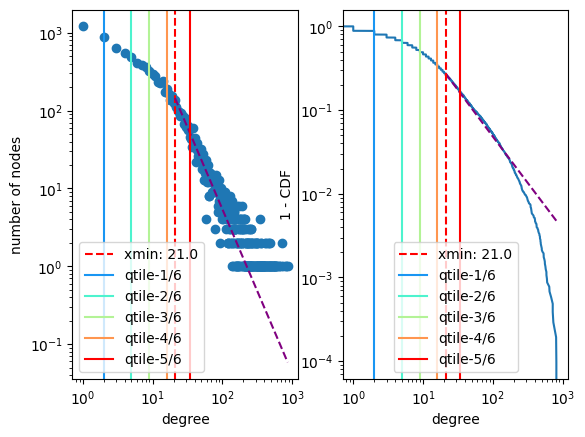

In [10]:
plotting.plot_degree_dist(gthresh, vlines=6, pl_fit=True)

In [11]:
adf_mini = adf.set_index('ident')
adf_mini = adf_mini.loc[airports]

# reversed s.t. latitude then longitude
adf_mini['coordinates'] = adf_mini.coordinates.apply(lambda x: tuple(reversed([float(y) for y in x.split(', ')])))

adf_mini['lat'] = adf_mini['coordinates'].apply(lambda x: x[0])
adf_mini['long'] = adf_mini['coordinates'].apply(lambda x: x[1])


In [12]:
from geopy import distance

In [13]:
dists = pd.read_csv('airport_distances3.csv.gz')

In [14]:
dists.head()

,Unnamed: 0,ident,00AK,00AL,00AZ,00CL,00FA,00GA,00ID,00IL,...,YYNG,YYOR,YYRK,YYRM,YZCE,Z19O,ZGGG,ZGSD,ZGSZ,ZUCK
0,0,00AK,0.000000,5349.974219,4031.313953,3090.913579,6160.861618,5597.685971,2624.290470,4588.083436,...,11793.368335,12335.258127,13092.521568,12279.402422,10940.267793,9538.732344,8055.052259,8181.755727,8098.583026,7805.232639
1,1,00AL,5349.974219,0.000000,2324.456065,3129.788327,813.072495,276.870514,2840.512023,826.243658,...,15041.578634,16004.551823,17812.910704,15291.485510,14405.932770,10295.357189,13219.621421,13362.340135,13281.442748,12719.047508
2,2,00AZ,4031.313953,2324.456065,0.000000,1026.459060,2902.851009,2586.987864,1573.474113,2148.411670,...,12838.214527,13767.080535,15490.615548,13155.315096,12139.509525,11708.704794,12021.825087,12137.284974,12054.551262,11834.790477
3,3,00CL,3090.913579,3129.788327,1026.459060,0.000000,3808.023298,3405.451955,1065.973722,2720.116619,...,12322.898713,13193.702330,14745.928966,12695.771474,11560.525005,11521.142414,11011.046593,11123.670073,11041.193486,10862.957523
4,4,00FA,6160.861618,813.072495,2902.851009,3808.023298,0.000000,594.573226,3627.065931,1621.317935,...,15237.780207,16215.422832,18165.876494,15404.310732,14706.867858,10469.324110,14012.640431,14157.147004,14076.906000,13477.241248


In [15]:
dists = dists.iloc[:, 1:]
dists = dists.set_index('ident')

In [16]:
dists_np = dists.to_numpy()

In [17]:
dists_np.shape

(10317, 10317)

In [18]:
a, b = adf_mini.loc['00AK'].coordinates, adf_mini.loc['00AZ'].coordinates
a, b
distance.distance(a, b)

((59.94919968, -151.695999146), (34.305599212646484, -112.16500091552734))

Distance(4031.313953084402)

In [19]:
dists_np[0, 2]

4031.313953084402

In [20]:
# 0.5 circumference of the earth (and dists_np.max()) is roughly 20000 km
dists_np = dists_np * np.sqrt(2)/20000

In [21]:
dists_np.max()

1.414097672012551

In [22]:
# sub_indices = np.random.choice(dists_np.shape[0], 4000)
# dists_np2 = dists_np[sub_indices][:, sub_indices]
# gthresh2 = quick_subgraph(gthresh, sub_indices)

In [23]:
# degrees = np.array([gthresh2.degree(i) for i in range(gthresh2.numberOfNodes())]).astype(np.float64)
# degrees[:10]

In [24]:
delta = 0.001
degrees = np.array([gthresh.degree(i) for i in range(gthresh.numberOfNodes())]).astype(np.float64)
degrees[degrees == 0] += delta
weights = degrees / len(degrees)

In [25]:
nk.overview(gthresh)

Network Properties:
nodes, edges			10317, 130704
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.002456
clustering coefficient		0.369664
min/max/avg degree		0, 864, 25.337598
degree assortativity		-0.013060
number of connected components	29
size of largest component	10274 (99.58 %)


In [26]:
 from girg_sampling import girgs

In [27]:
weights = list(weights)

In [28]:
desiredAvgDegree = 25.337598
d = 2
n = 10317
alpha = 1.5
tau=2.103

In [31]:
desiredAvgDegree = 25.337598
alpha, d, desiredAvgDegree

(1.5, 2, 25.337598)

In [33]:
const = girgs.scaleWeights(weights, desiredAvgDegree, d, alpha)
const

939.5682338805269

In [34]:
scaled_weights = list(np.array(weights) * const)

In [ ]:
desiredAvgDegree = 25.337598
d = 2
n = 10317
alpha = 1.5
tau=2.103

"""Generate a GIRG with C-library"""
# weights = girgs.generateWeights(n, tau)
scaled_weights = weights
const = 1
if desiredAvgDegree is not None:
    const = girgs.scaleWeights(weights, desiredAvgDegree, d, alpha)
    scaled_weights = list(np.array(weights) * const)
    
    
pts = girgs.generatePositions(n, d)
edges = girgs.generateEdges(scaled_weights, pts, alpha)
# Make graph from edge list (not adjacency matrix)
gnx = nx.from_edgelist(edges)
missing_nodes = set(list(range(n)))
for node in gnx.nodes:
    missing_nodes.remove(node)

for missing_node in missing_nodes:
    gnx.add_node(missing_node)

gnk = nk.nxadapter.nx2nk(gnx)
# id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

# return gnk, edges, weights, pts, const, id2gnk

In [7]:
nk.overview(gnk)

Network Properties:
nodes, edges			10317, 130853
directed?			False
weighted?			False
isolated nodes			5
self-loops			0
density				0.002459
clustering coefficient		0.599425
min/max/avg degree		0, 3657, 25.366483
degree assortativity		-0.128916
number of connected components	6
size of largest component	10312 (99.95 %)


In [ ]:
alphas = np.linspace(1.3, 1.9, 10)
consts = np.linspace(0.7*1.3*35/25 , 0.7*80/25 * 1.3, 10)
for alpha, const in zip(alphas, consts):
    asdf.alpha = alpha
    asdf.const = const
    g_girg = asdf.gen_new_girg()
    print(f'alpha: {alpha:.3f}; const: {const:.3f}')
    print(f'avg degrees: {utils.avg_degree(g_girg):.3f}, {utils.avg_degree(gthresh):.3f}')
    a, b = compare_two_graphs(g_girg, gthresh)
    print(f'girg missing %: {a:.3f}, true missing %: {b:.3f}')